In [1]:
from help_funcs.evaluation import evaluate_model, epistemic, get_pca_plots
from sklearn.metrics import f1_score 

# GCN Multi-class

train loss: 0.9816800355911255, accuracy: 57.82, f1:0.34
val loss: 0.97920161485672, accuracy: 44.44, f1:0.23
test loss: 1.2514183521270752, accuracy: 42.86, f1:0.21


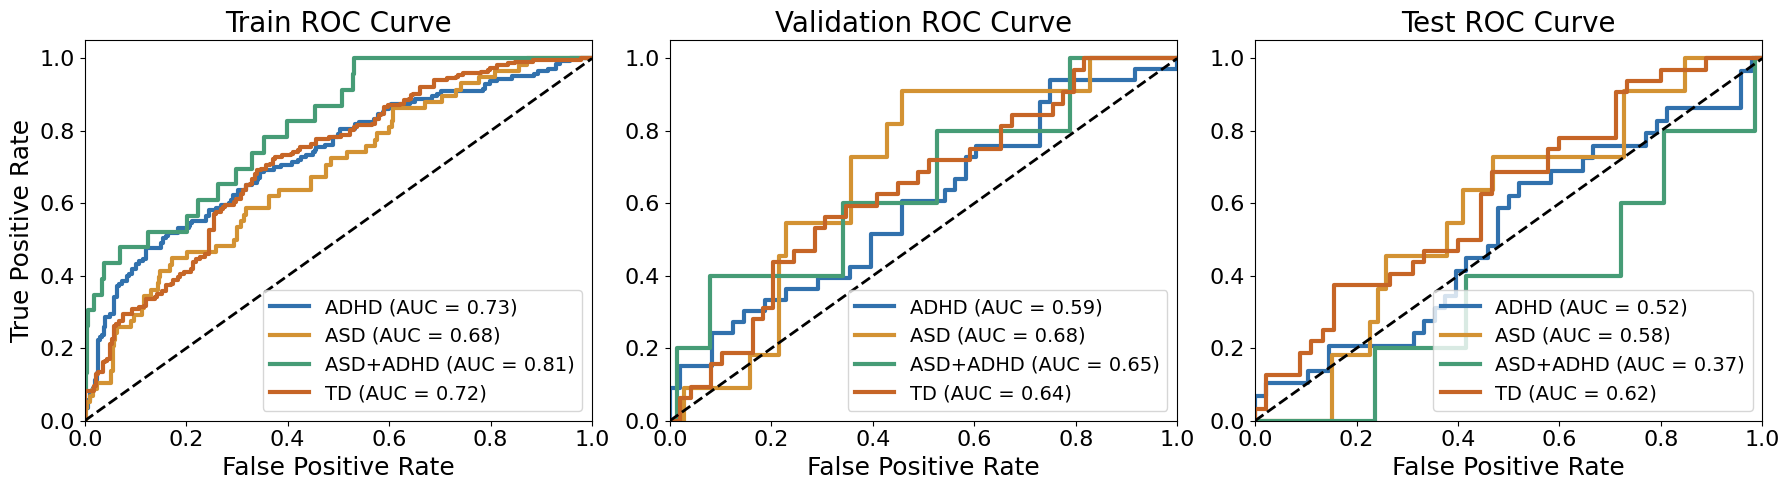

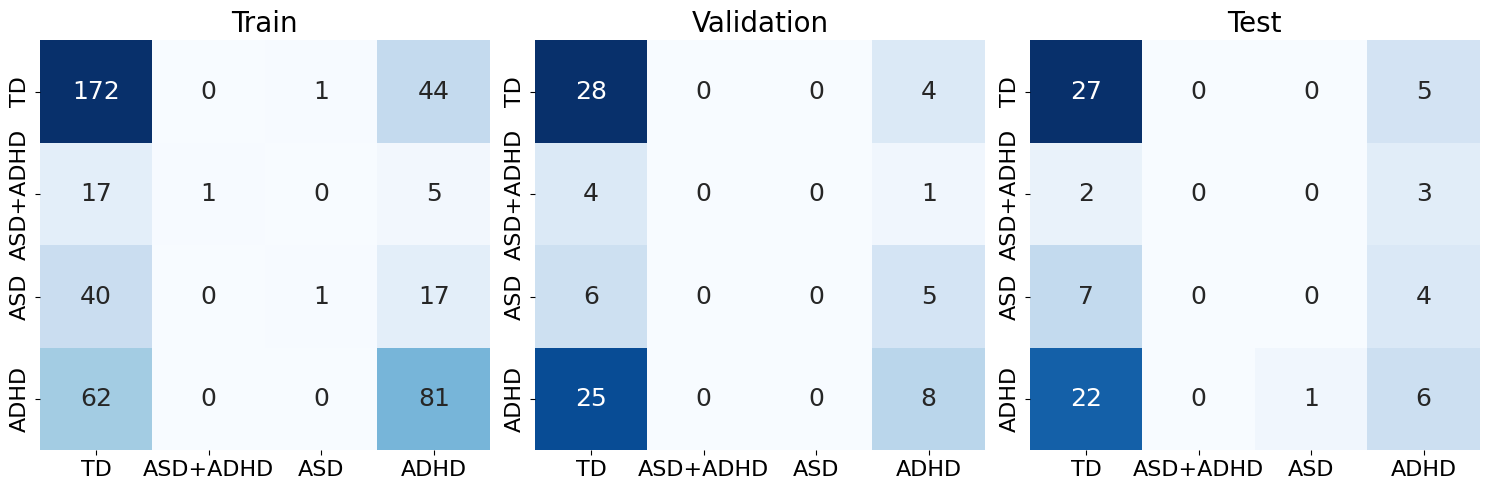

['TD', 'TD', 'TD', 'ADHD', 'ADHD', 'TD', 'ASD', 'TD', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD-Other', 'TD', 'ASD', 'ADHD-Other', 'TD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'TD', 'TD', 'TD', 'TD', 'ADHD-Other', 'TD-Other', 'ASD', 'TD-Other', 'ASD', 'ASD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'ADHD-Other', 'TD', 'TD', 'TD', 'TD', 'ADHD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'TD', 'TD', 'ASD-Other', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'ASD-ADHD', 'TD', 'ADHD', 'ADHD', 'ASD-ADHD', 'ASD-Other', 'ADHD', 'ADHD', 'ADHD-Other', 'TD', 'ADHD', 'TD', 'TD', 'ADHD', 'ASD', 'TD', 'TD', 'ASD', 'TD', 'TD', 'ADHD-Other', 'ASD-Other', 'TD', 'ASD-ADHD', 'ADHD-Other', 'ADHD', 'TD', 'ADHD-Other', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'ADHD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'TD', 'TD', 'TD-Other', 'ADHD', 'ASD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-Other', 'TD', 'ADHD', 'TD', 'ADHD', 'ASD-ADHD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'ASD', 'ASD', '

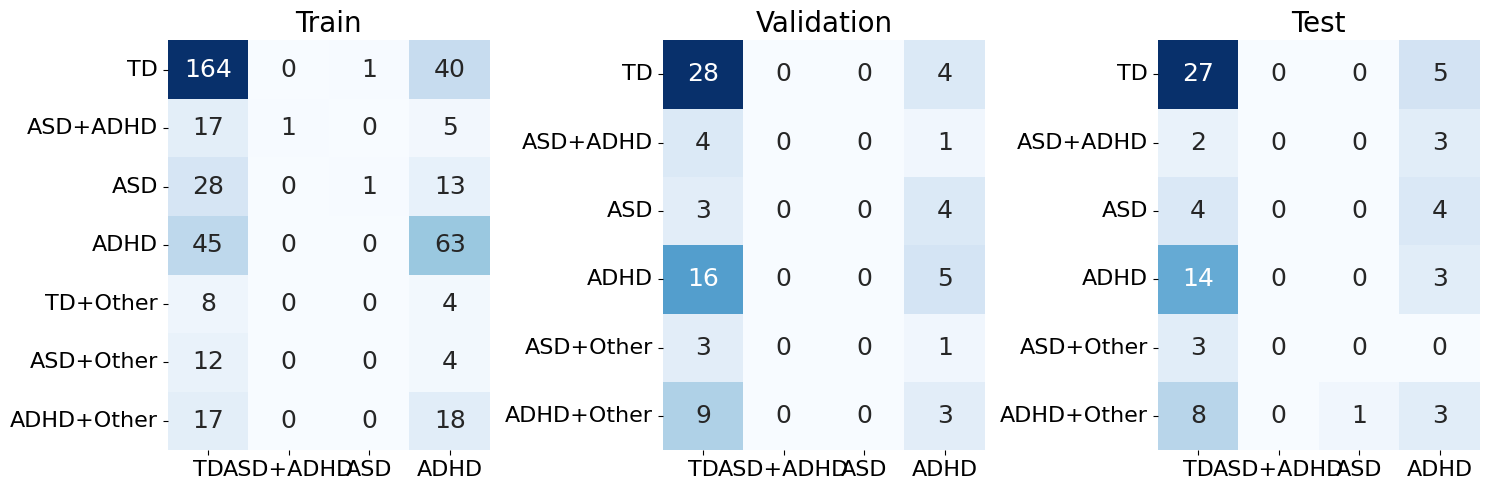

In [2]:
softmax_data = evaluate_model(yaml_file = "saved_models/GCN_Multi_absolute_weights.yaml", 
                              model_file = "saved_models/GCN_Multi_absolute_weights.pt", 
                              drop_strategy = None, 
                              gat = False) 

# GCN Binary-class

train loss: 0.554794430732727, accuracy: 69.39, f1:0.69
val loss: 0.5222153067588806, accuracy: 65.43, f1:0.65
test loss: 0.5780280828475952, accuracy: 61.04, f1:0.61


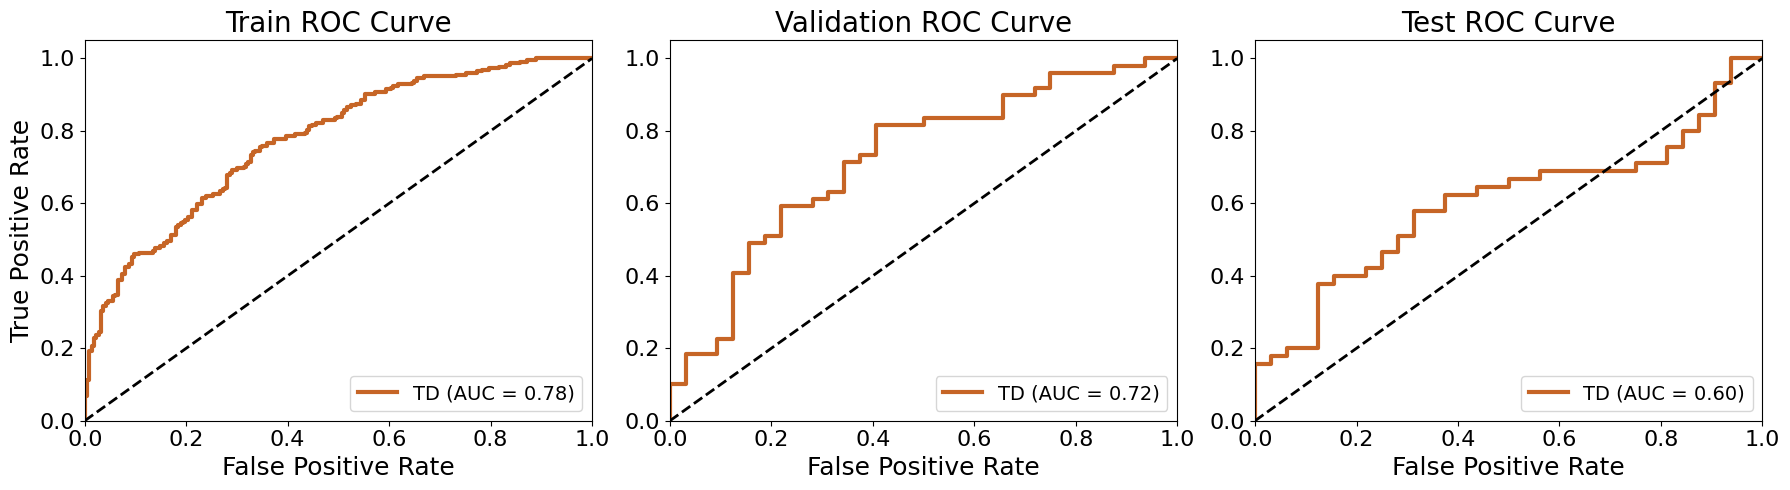

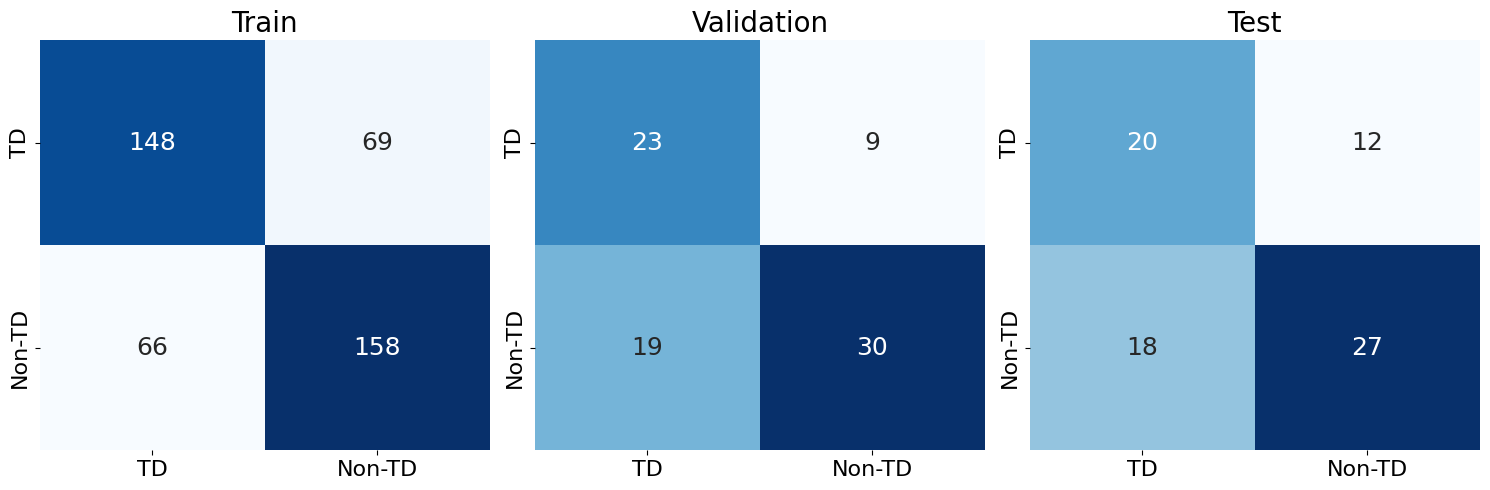

['TD', 'TD', 'TD', 'ADHD', 'ADHD', 'TD', 'ASD', 'TD', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD-Other', 'TD', 'ASD', 'ADHD-Other', 'TD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'TD', 'TD', 'TD', 'TD', 'ADHD-Other', 'TD-Other', 'ASD', 'TD-Other', 'ASD', 'ASD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'ADHD-Other', 'TD', 'TD', 'TD', 'TD', 'ADHD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'TD', 'TD', 'ASD-Other', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'ASD-ADHD', 'TD', 'ADHD', 'ADHD', 'ASD-ADHD', 'ASD-Other', 'ADHD', 'ADHD', 'ADHD-Other', 'TD', 'ADHD', 'TD', 'TD', 'ADHD', 'ASD', 'TD', 'TD', 'ASD', 'TD', 'TD', 'ADHD-Other', 'ASD-Other', 'TD', 'ASD-ADHD', 'ADHD-Other', 'ADHD', 'TD', 'ADHD-Other', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'ADHD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'TD', 'TD', 'TD-Other', 'ADHD', 'ASD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-Other', 'TD', 'ADHD', 'TD', 'ADHD', 'ASD-ADHD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'ASD', 'ASD', '

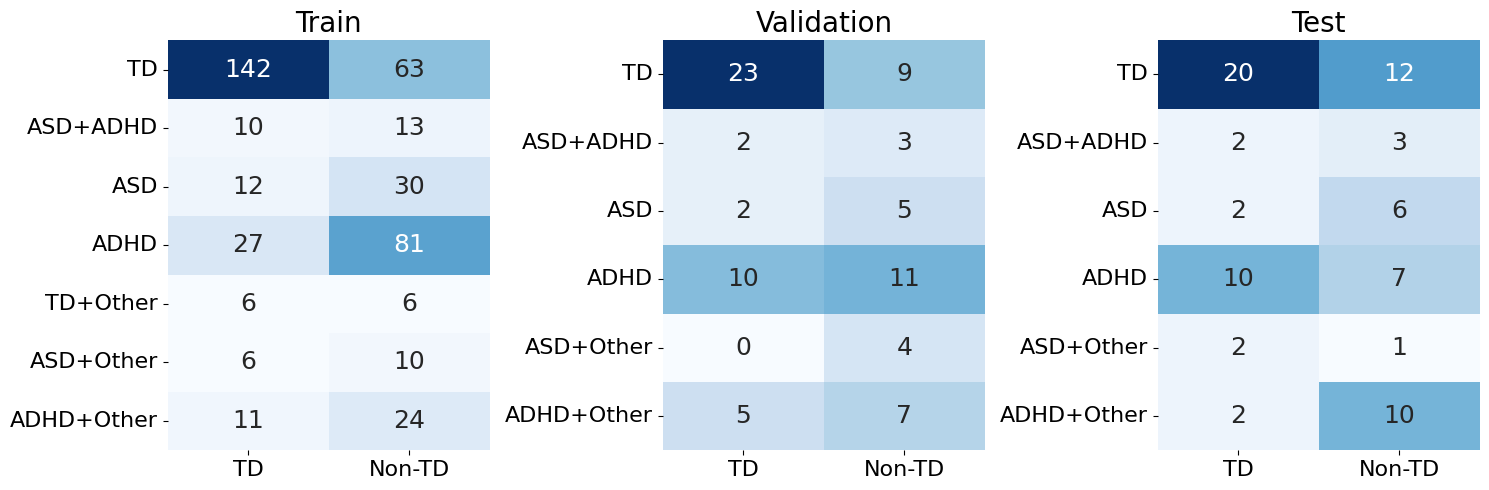

,label,predicted,softmax_values
0,TD,Not-TD,[0.5472467541694641]
1,TD,TD,[0.4733259975910187]
2,TD,Not-TD,[0.6302390694618225]
3,Not-TD,Not-TD,[0.5881670713424683]
4,Not-TD,Not-TD,[0.7684990167617798]
...,...,...,...
436,Not-TD,Not-TD,[0.500506579875946]
437,Not-TD,Not-TD,[0.7893200516700745]
438,TD,TD,[0.4699714183807373]
439,TD,TD,[0.29943716526031494]


In [3]:
evaluate_model(yaml_file = "saved_models/GCN_Binary_absolute_weights.yaml", 
               model_file = "saved_models/GCN_Binary_absolute_weights.pt", 
               drop_strategy = None, 
               gat = False)

# GAT Multi-class

train loss: 0.8160125017166138, accuracy: 66.21, f1:0.52
val loss: 0.909799337387085, accuracy: 56.79, f1:0.35
test loss: 1.3263485431671143, accuracy: 37.66, f1:0.21


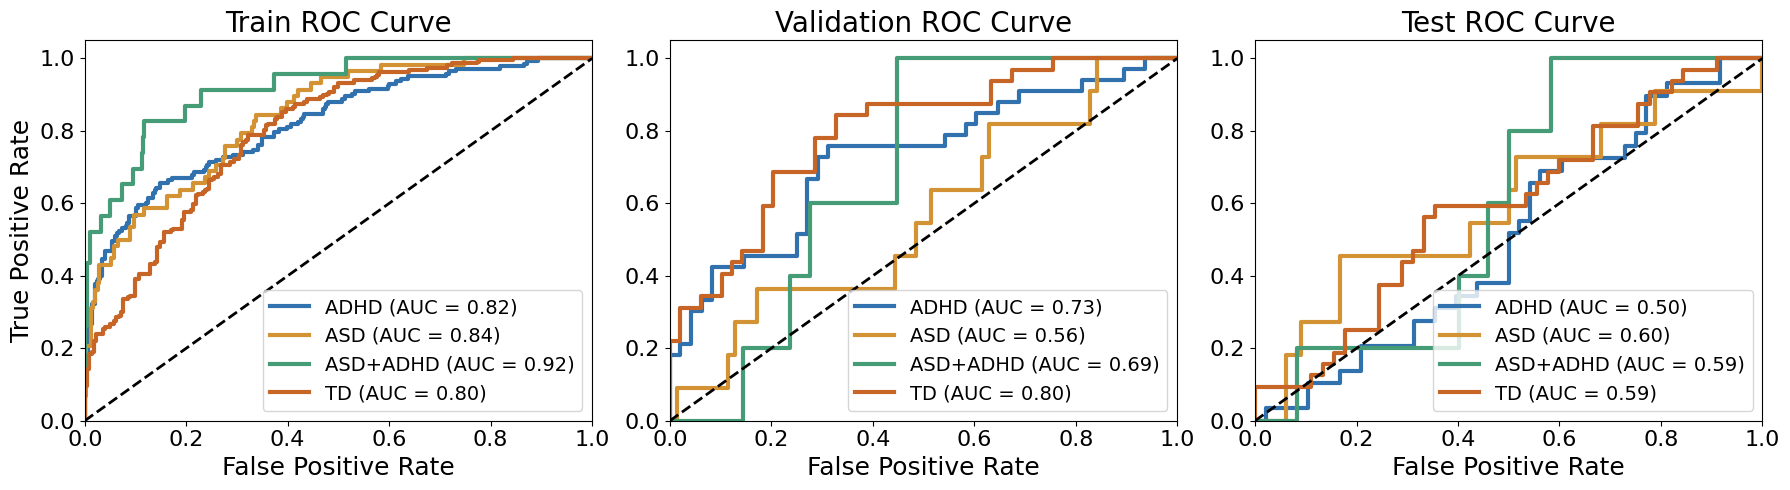

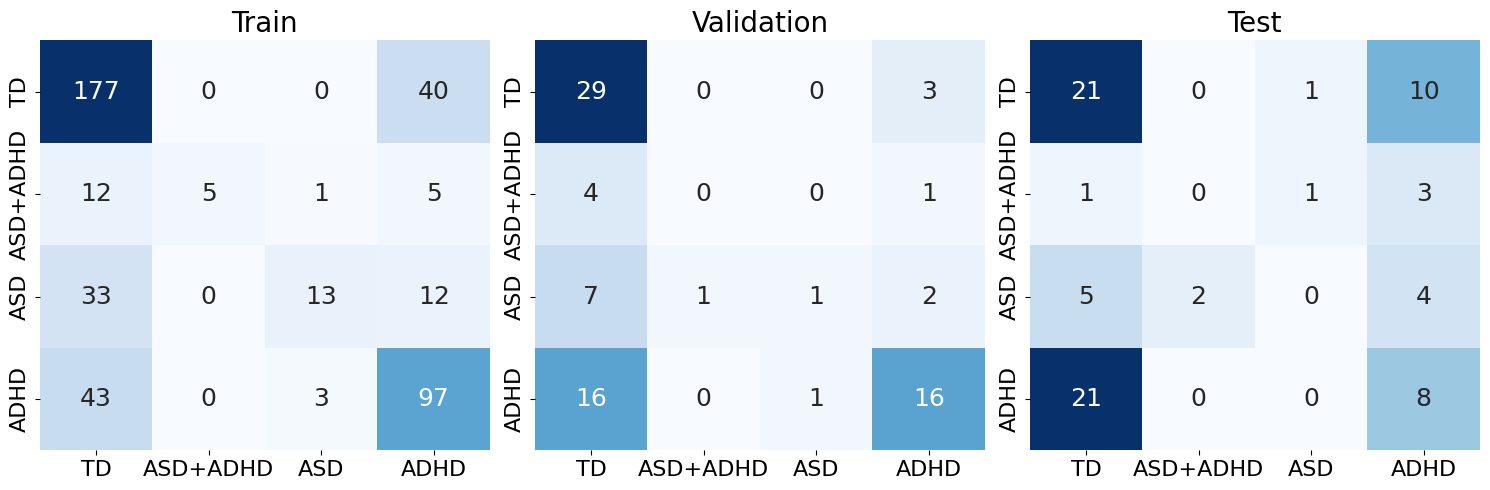

['TD', 'TD', 'TD', 'ADHD', 'ADHD', 'TD', 'ASD', 'TD', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD-Other', 'TD', 'ASD', 'ADHD-Other', 'TD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'TD', 'TD', 'TD', 'TD', 'ADHD-Other', 'TD-Other', 'ASD', 'TD-Other', 'ASD', 'ASD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'ADHD-Other', 'TD', 'TD', 'TD', 'TD', 'ADHD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'TD', 'TD', 'ASD-Other', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'ASD-ADHD', 'TD', 'ADHD', 'ADHD', 'ASD-ADHD', 'ASD-Other', 'ADHD', 'ADHD', 'ADHD-Other', 'TD', 'ADHD', 'TD', 'TD', 'ADHD', 'ASD', 'TD', 'TD', 'ASD', 'TD', 'TD', 'ADHD-Other', 'ASD-Other', 'TD', 'ASD-ADHD', 'ADHD-Other', 'ADHD', 'TD', 'ADHD-Other', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'ADHD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'TD', 'TD', 'TD-Other', 'ADHD', 'ASD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-Other', 'TD', 'ADHD', 'TD', 'ADHD', 'ASD-ADHD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'ASD', 'ASD', '

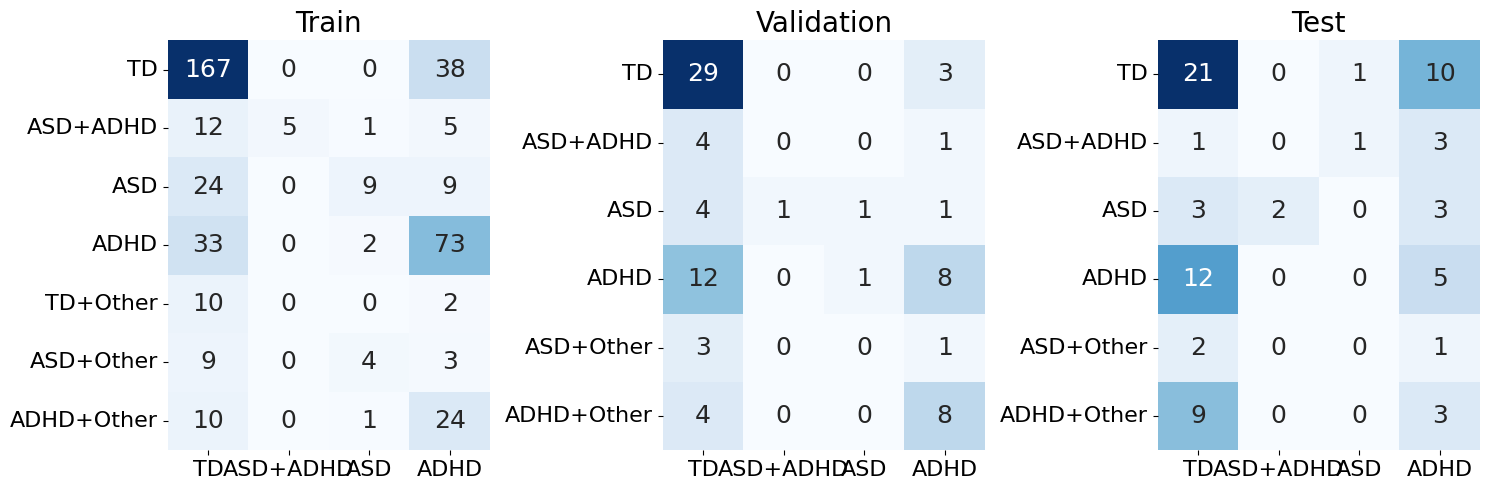

In [4]:
softmax_data = evaluate_model(yaml_file = "saved_models/GAT_Multi_S2_relative.yaml", 
                            model_file = "saved_models/GAT_Multi_S2_relative.pt", 
                            drop_strategy = 2,
                            gat = True)

In [5]:
means = softmax_data[['label', 'predicted', 'TD', 'ASD+ADHD', 'ASD', 'ADHD']].groupby(['label', 'predicted']).mean().reset_index()
means['count'] = softmax_data[['label', 'predicted', 'TD']].groupby(['label', 'predicted']).count().reset_index()['TD']

In [6]:
d = epistemic(yaml_file = "saved_models/GAT_Multi_S2_relative.yaml", 
            model_file = "saved_models/GAT_Multi_S2_relative.pt", 
            dropout = 0.25, 
            forward_passes = 100,
            drop_strategy = 2, 
            gat = True,
            data_set = 'val')
f1_score(d['Label'], d['Predicted'], average='macro')

0.27667493796526055

********* BEFORE *********
Number of features: 272
Explained variance ratio: [0.2390044  0.10112435]
********* AFTER *********
Number of features: 8704
Explained variance ratio: [0.22639014 0.14022556]


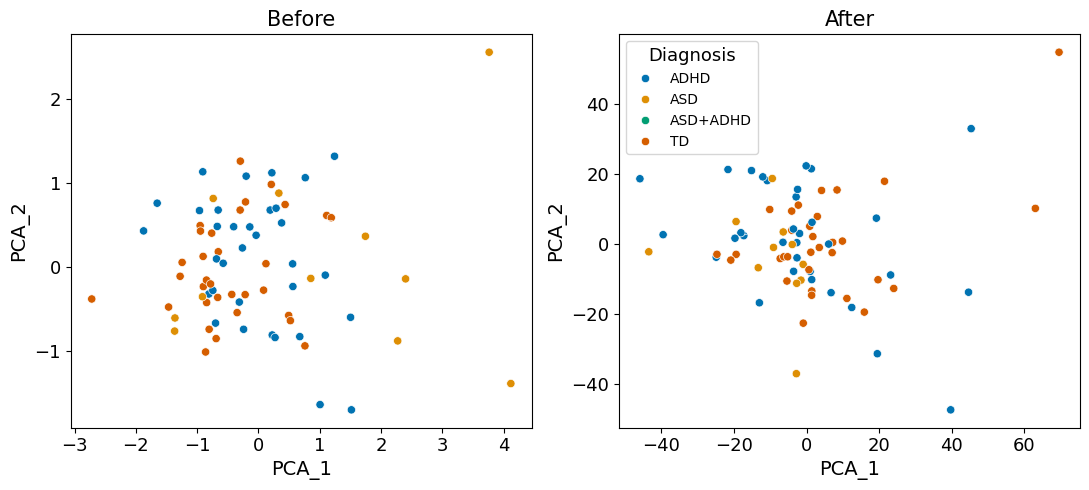

In [7]:
before, after = get_pca_plots(yaml_file = "saved_models/GAT_Multi_S2_relative.yaml", 
                                model_file = "saved_models/GAT_Multi_S2_relative.pt", 
                                drop_strategy = 2, 
                                gat = True, 
                                dataset = 'val')

# GAT Binary

train loss: 0.4492197036743164, accuracy: 74.38, f1:0.74
val loss: 0.3664683401584625, accuracy: 74.07, f1:0.72
test loss: 0.7494198083877563, accuracy: 61.04, f1:0.57


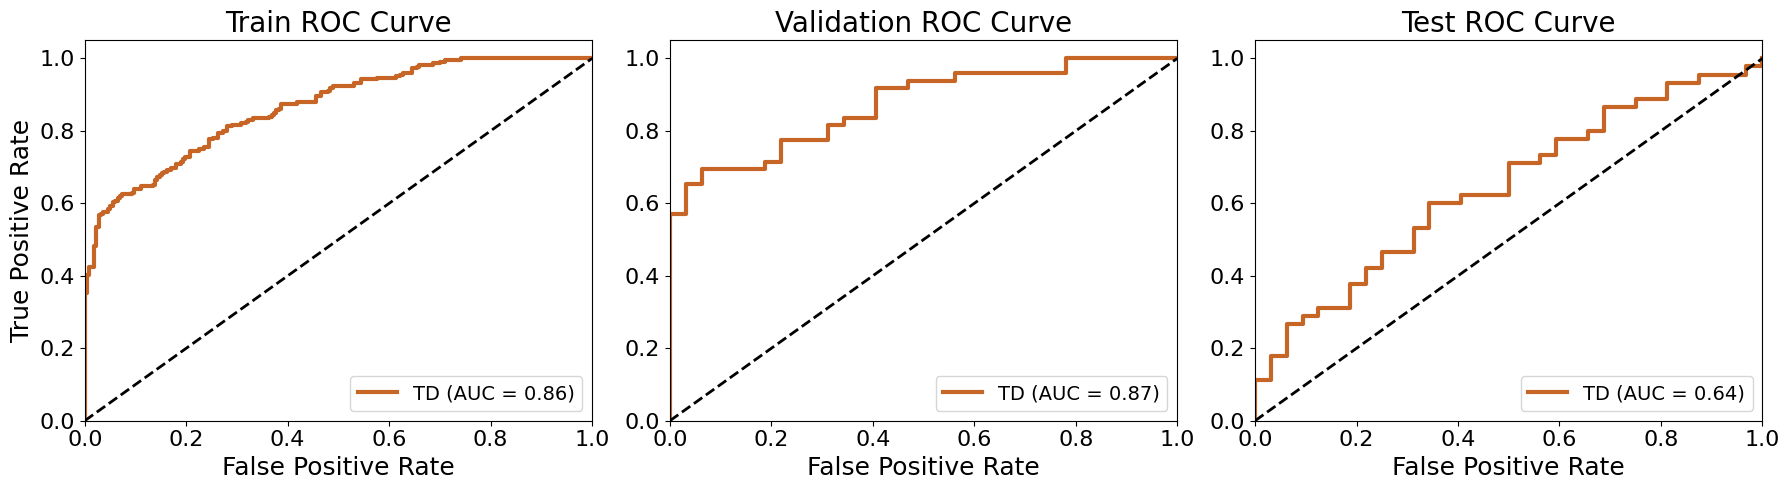

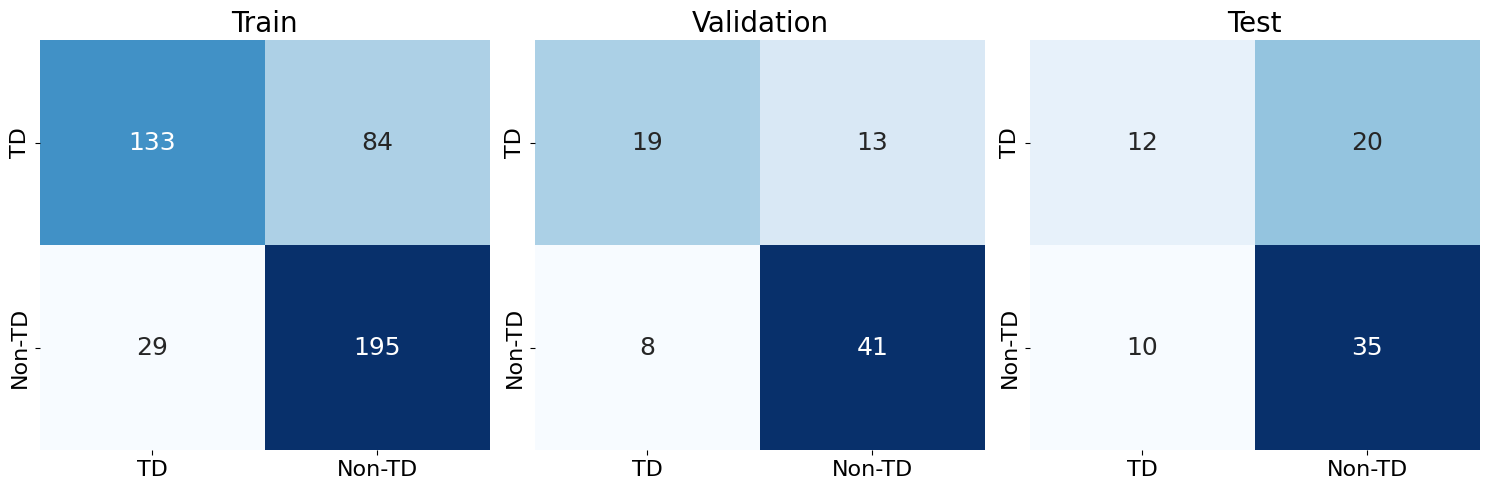

['TD', 'TD', 'TD', 'ADHD', 'ADHD', 'TD', 'ASD', 'TD', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD-Other', 'TD', 'ASD', 'ADHD-Other', 'TD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'TD', 'TD', 'TD', 'TD', 'ADHD-Other', 'TD-Other', 'ASD', 'TD-Other', 'ASD', 'ASD', 'ASD-ADHD', 'ADHD', 'TD', 'TD', 'ADHD-Other', 'TD', 'TD', 'TD', 'TD', 'ADHD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'TD', 'TD', 'ASD-Other', 'ADHD', 'TD', 'TD', 'TD', 'ADHD', 'ASD-ADHD', 'TD', 'ADHD', 'ADHD', 'ASD-ADHD', 'ASD-Other', 'ADHD', 'ADHD', 'ADHD-Other', 'TD', 'ADHD', 'TD', 'TD', 'ADHD', 'ASD', 'TD', 'TD', 'ASD', 'TD', 'TD', 'ADHD-Other', 'ASD-Other', 'TD', 'ASD-ADHD', 'ADHD-Other', 'ADHD', 'TD', 'ADHD-Other', 'TD', 'TD', 'ASD', 'ADHD', 'ADHD', 'ADHD', 'TD-Other', 'ADHD-Other', 'ADHD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'TD', 'TD', 'TD-Other', 'ADHD', 'ASD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-Other', 'TD', 'ADHD', 'TD', 'ADHD', 'ASD-ADHD', 'ADHD', 'ASD', 'ADHD', 'TD', 'ASD-ADHD', 'TD', 'ADHD', 'ASD', 'ASD', '

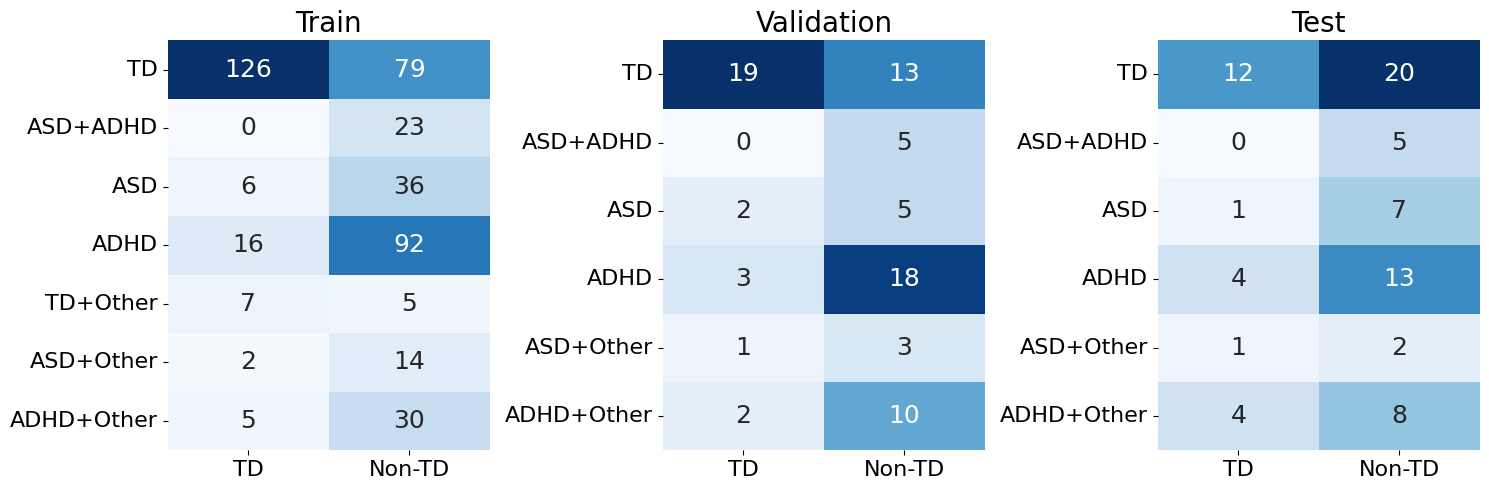

In [8]:
softmax_data = evaluate_model(yaml_file = "saved_models/GAT_Binary_S2_relative.yaml", 
                                model_file = "saved_models/GAT_Binary_S2_relative.pt", 
                                drop_strategy = 2,
                                gat = True)

********* BEFORE *********
Number of features: 272
Explained variance ratio: [0.2390044  0.10112435]
********* AFTER *********
Number of features: 4352
Explained variance ratio: [0.24847601 0.19217242]


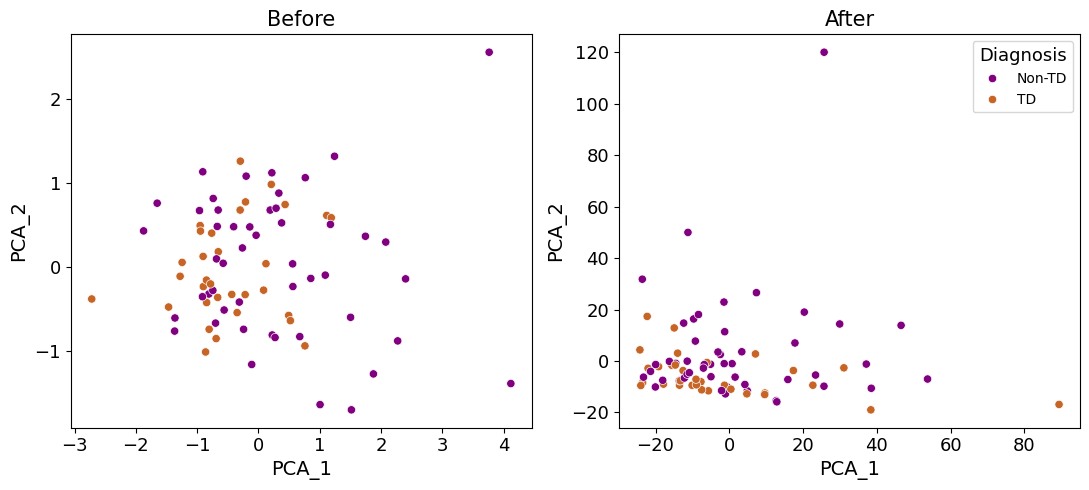

In [9]:
before, after = get_pca_plots(yaml_file = "saved_models/GAT_Binary_S2_relative.yaml", 
                                model_file = "saved_models/GAT_Binary_S2_relative.pt", 
                                drop_strategy = 2,
                                gat = True,
                                dataset = 'val')

# Logistic confusion matrices

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [15]:
def plot_confusion_matrix(num_of_classes, cf, extended = False, fig_name = None):
    split_names = ['train', 'val', 'test']

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    
    for ax, split_name in zip(axes, split_names):
        class_labels_legends_extended = ['TD', 'ASD+ADHD', 'ASD', 'ADHD', 'TD+Other', 'ASD+Other', 'ADHD+Other']

        if num_of_classes == 4:
            class_labels_legends = ['TD', 'ASD+ADHD', 'ASD', 'ADHD']
            temp_label = {'TD':0, 'ASD+ADHD':1, 'ASD':2, 'ADHD':3, 'TD+Other':4, 'ASD+Other': 5, 'ADHD+Other': 6}
        else: 
            class_labels_legends = ['TD', 'Non-TD']
            temp_label = {'TD':0, 'ASD+ADHD':1, 'ASD':2, 'ADHD':3, 'TD+Other':4, 'ASD+Other': 5, 'ADHD+Other': 6}
        
        sns.heatmap(cf[split_name], 
                    yticklabels= class_labels_legends,
                    xticklabels = class_labels_legends,
                    annot=True,
                    fmt='d',
                    ax = ax,
                    cmap='Blues',
                    annot_kws={'size': 18},
                    cbar=False)
        split_name = 'Validation' if split_name.lower() == 'val' else split_name
        ax.set_title(split_name.capitalize(), fontsize=20)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
    
    plt.tight_layout()
    if not extended:
        plt.savefig(f'pics/{fig_name}.svg', dpi = 300)
    plt.show()

(2, 2)


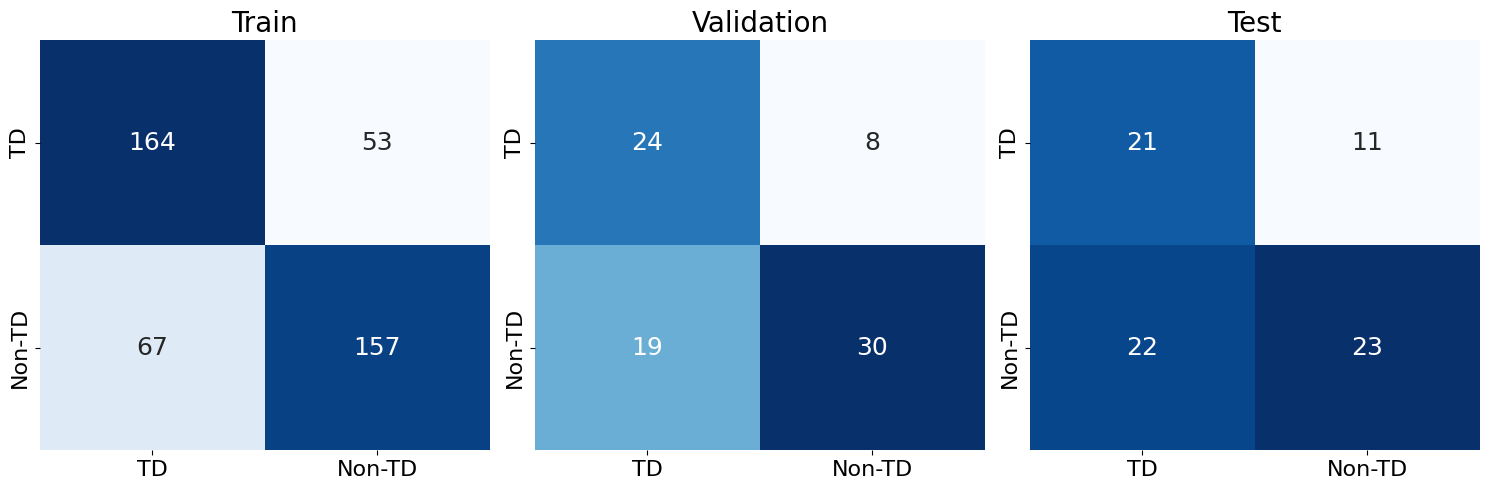

In [16]:
logistic_binary = {"train": np.array([[164, 53],
                                      [67, 157]]),
                    'val': np.array([[24, 8],
                                    [19, 30]]),
                    'test': np.array([[21, 11],
                                    [22, 23]])
                }
 
print(logistic_binary['train'].shape)
plot_confusion_matrix(2, cf = logistic_binary, extended = False, fig_name = 'logistic_binary_confusion_matrix')

(4, 4)


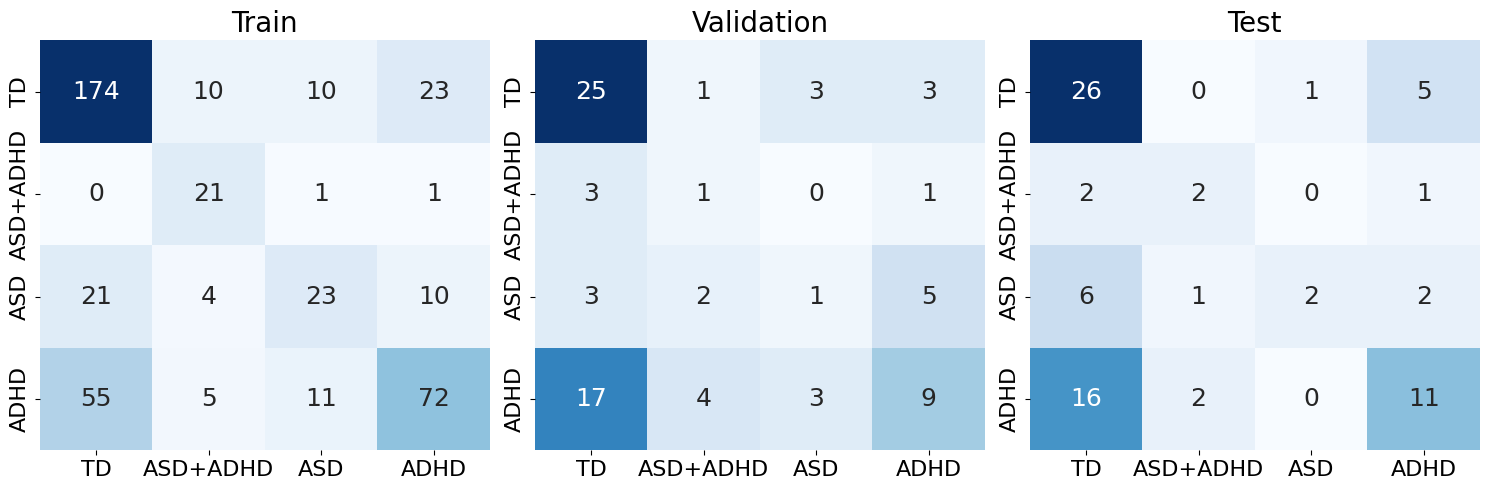

In [17]:
logistic_multi = {"train": np.array([[174, 10, 10, 23],
                                    [0, 21, 1, 1],
                                    [21, 4, 23, 10],
                                    [55, 5, 11, 72]
                                ]),
                    'val': np.array([[25, 1, 3, 3],
                                    [3, 1, 0, 1],
                                    [3, 2, 1, 5],
                                    [17, 4, 3, 9]
                                ]),
                    'test': np.array([[26, 0, 1, 5],
                                      [2, 2, 0, 1],
                                      [6, 1, 2, 2],
                                      [16, 2, 0, 11]
                                            ])
                }

print(logistic_multi['train'].shape)
plot_confusion_matrix(4, cf = logistic_multi, extended = False, fig_name = 'logistic_multi_confusion_matrix')